#### Perform preprocessing of the combined snRNA-seq ENCODE v4 LV samples

In [1]:
import numpy as np
import scanpy as sc 
import pandas as pd 
import matplotlib.pyplot as plt
import re
import os

In [2]:
def preprocess_adata(adata, donor_key, leiden_resolution):
    '''
    Performs: 
    1. library size normalization and log scaling
    2. identification of top 2K highly variable genes, 
    3. Principal component analysis
    4. Harmony integration
    5. Neighbor neighbors computation in Harmony integration embedding
    6. Leiden clustering 
    
    Parameters:
    adata (AnnData): adata object before preprocessing
    donor_key: the column in adata.obs that corresponds to the donor information (should be 'donor_id')
    leiden_resolution: resolution for leiden clustering, higher means more clusters will be detected

    Returns:
    adata: Postprocessed adata
    '''
    # Normalizing to median total counts
    sc.pp.normalize_total(adata)
    # Logarithmize the data
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key=donor_key)
    sc.tl.pca(adata)
    sce.pp.harmony_integrate(adata, donor_key)
    sc.pp.neighbors(adata, use_rep = "X_pca_harmony")
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=donor_key, size=2)
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution = 0.5)
    return(adata)

Load in the combined ENCODE v4 adata

In [3]:
adata = sc.read_h5ad("02_combined_ENCODE_LV_snRNA.h5ad")

In [4]:
adata.layers["counts"] = adata.X

In [5]:
# confirm that the counts are raw
adata.X.sum(axis = 1)

matrix([[ 2070.9998],
        [ 8602.    ],
        [12192.999 ],
        ...,
        [ 1107.    ],
        [12429.    ],
        [ 1573.9999]], dtype=float32)

In [6]:
%%time
# in some cases the counts are NOT integers, so round to nearest interest 
adata.X = np.round(adata.X)

CPU times: user 4.01 s, sys: 4.51 s, total: 8.52 s
Wall time: 8.52 s


In [7]:
adata.obs

,age,sex,sample,directory
ENCSR906MRL:AAACAGCCAAATTCGT,44,male,ENCSR906MRL,ENCFF201LRF
ENCSR906MRL:AAACAGCCAATTAGGA,44,male,ENCSR906MRL,ENCFF201LRF
ENCSR906MRL:AAACAGCCAATTGAAG,44,male,ENCSR906MRL,ENCFF201LRF
ENCSR906MRL:AAACAGCCACAATTAC,44,male,ENCSR906MRL,ENCFF201LRF
ENCSR906MRL:AAACAGCCACCGGTAT,44,male,ENCSR906MRL,ENCFF201LRF
...,...,...,...,...
ENCSR899GYX:TTTGTTGGTCAAGACC,58,male,ENCSR899GYX,ENCFF004QRO
ENCSR899GYX:TTTGTTGGTCACCAAA,58,male,ENCSR899GYX,ENCFF004QRO
ENCSR899GYX:TTTGTTGGTGCGCATG,58,male,ENCSR899GYX,ENCFF004QRO
ENCSR899GYX:TTTGTTGGTGCGCGTA,58,male,ENCSR899GYX,ENCFF004QRO


In [8]:
# extract the relevant metadata
metadata = adata.obs[['sample', 'sex', 'age', 'directory']]

# for later consistency, change the column names
metadata = metadata.rename(columns={'sample': 'donor_id'})

# add additional metadata columns
metadata['study'] = 'ENCODE v4 (Snyder)'
metadata['technology'] = 'Multiome-v1'
metadata['cell_or_nuclei'] = 'Nuclei'
metadata['region'] = 'LV'

# add back the metadata
adata.obs = metadata
adata.obs.head()

,donor_id,sex,age,directory,study,technology,cell_or_nuclei,region
ENCSR906MRL:AAACAGCCAAATTCGT,ENCSR906MRL,male,44,ENCFF201LRF,ENCODE v4 (Snyder),Multiome-v1,Nuclei,LV
ENCSR906MRL:AAACAGCCAATTAGGA,ENCSR906MRL,male,44,ENCFF201LRF,ENCODE v4 (Snyder),Multiome-v1,Nuclei,LV
ENCSR906MRL:AAACAGCCAATTGAAG,ENCSR906MRL,male,44,ENCFF201LRF,ENCODE v4 (Snyder),Multiome-v1,Nuclei,LV
ENCSR906MRL:AAACAGCCACAATTAC,ENCSR906MRL,male,44,ENCFF201LRF,ENCODE v4 (Snyder),Multiome-v1,Nuclei,LV
ENCSR906MRL:AAACAGCCACCGGTAT,ENCSR906MRL,male,44,ENCFF201LRF,ENCODE v4 (Snyder),Multiome-v1,Nuclei,LV


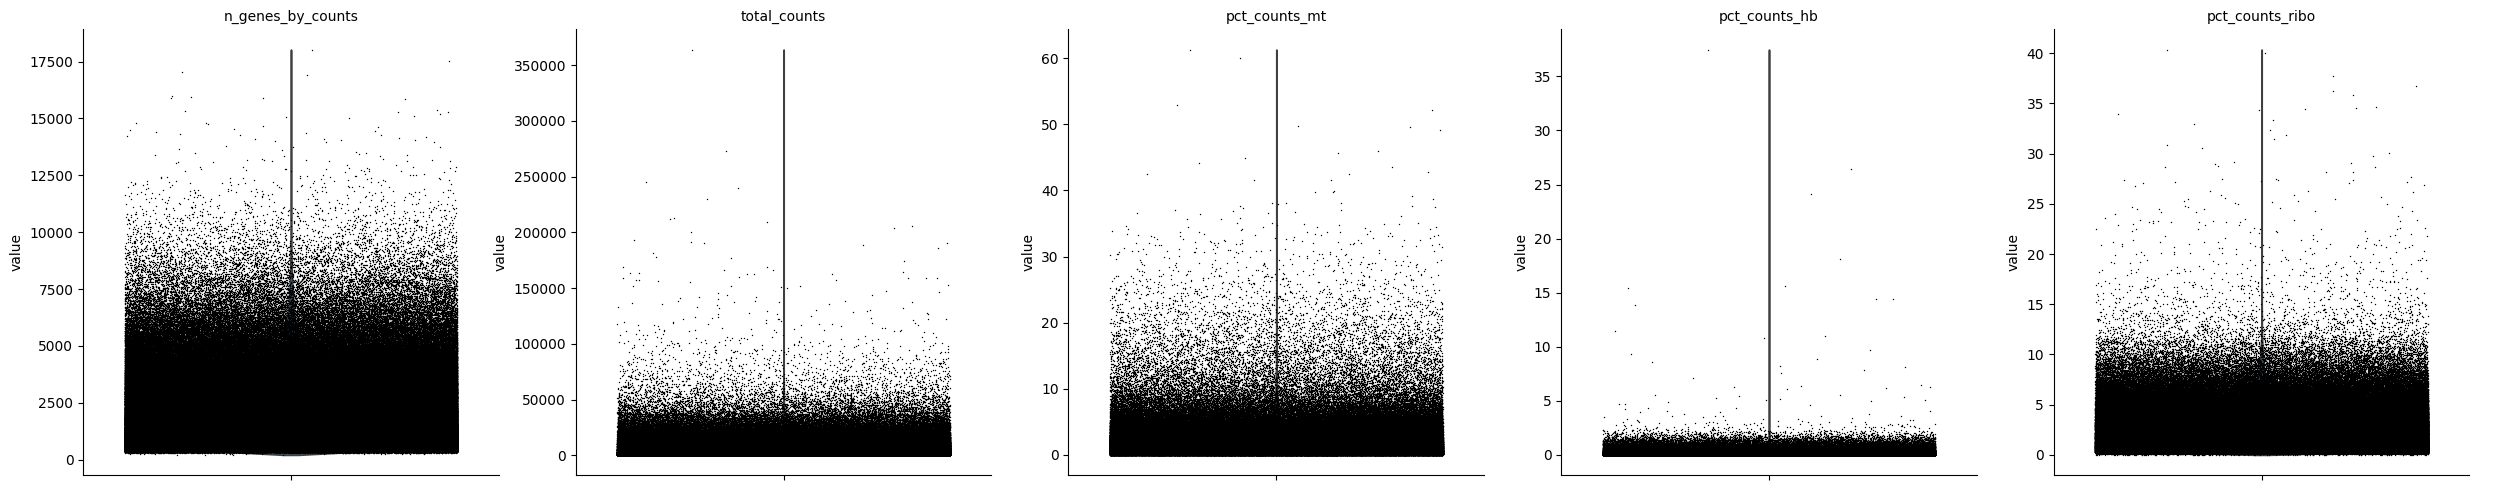

Filtered out 84883 cells
CPU times: user 3min 7s, sys: 1min 6s, total: 4min 14s
Wall time: 2min 19s


In [9]:
%%time 

adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_hb", "pct_counts_ribo"], 
             jitter=0.4,multi_panel=True,)

# filter the cells out that are above the specified thresholds for mitochondrial, ribosomal, and hemoglobin reads
mito_threshold = 5.0
ribo_threshold = 5.0
hb_threshold = 5.0 

adata_size_before = adata.shape[0]

adata = ( adata[(adata.obs.pct_counts_mt <= mito_threshold) &
                (adata.obs.pct_counts_ribo <= ribo_threshold) &
                (adata.obs.pct_counts_hb <= hb_threshold), :].copy()
        )

adata_size_after = adata.shape[0]
num_filtered = adata_size_before - adata_size_after
print(f"Filtered out {num_filtered} cells")

In [11]:
adata.write("03_prescrublet_combined_adata.h5ad")